# "Standard Candle" Toy 3: Brightness MNIST

Randomly adjust the brightness of each MNIST sample. The output of the network is still just the MNIST number label, not the brightness yet.

Note that this notebook should be run from the `notebooks/` subdirectory.

## Setup

In [328]:
# NOTE: Change this to what the notebook name is for each experiment to ensure
# training results are saved into the right sub-directory.
notebook_name = '03b_simple_toy1'

import random
import os
import shutil

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from PIL import Image

In [329]:
# Protective code to ensure we always reset the random seed when doing training, or else
# code won't be reproducible.
if 'training_runs_count' not in globals():
  training_runs_count = 0
if 'seed_reset_count' not in globals():
  seed_reset_count = 0

root_path = '../..' # Relative to: notebooks/01b_simple_toy
data_path = os.path.join(root_path, 'data', notebook_name)
results_path = os.path.join(root_path, 'training_results', notebook_name)
model_path = os.path.join(results_path, 'model.pth')
optimizer_path = os.path.join(results_path, 'optimizer.pth')

for path in [data_path, results_path]:
  if not os.path.exists(path):
    print('{} does not exist; creating directory...'.format(os.path.abspath(path)))
    os.makedirs(path)

n_epochs = 8
batch_size_train = 64
batch_size_test = 1000
log_interval = 10

In [330]:
cuda_device = 0
torch.backends.cudnn.enabled = True
if not torch.cuda.is_available():
  raise RuntimeError("CUDA not available! Unable to continue")
# Force ourselves to use only one GPU.
device = torch.device("cuda:{}".format(cuda_device))
print("Using device {} for training, current device: {}, total devices: {}".format(
  device, torch.cuda.current_device(), torch.cuda.device_count()))

random_seed = 1
np.random.seed(random_seed)
random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(random_seed)
seed_reset_count += 1

Using device cuda:0 for training, current device: 0, total devices: 6


In [331]:
class BrightnessMNIST(torchvision.datasets.MNIST):
  
  # TODO: Use dynamic arguments to not have to hard code these params from torchvision.datsets.MNIST.
  def __init__(self, root, train=True, transform=None, target_transform=None, download=False):
    super(BrightnessMNIST, self).__init__(root, train, transform, target_transform, download)
    self._precompute_brightness()
    self._compute_statistics()
    
  def _precompute_brightness(self):
    # Randomly compute what the brightness setting should be for each sample.
    # NOTE: Below 30% brightness accuracy degrades vs. the experiment 2 baseline.
    self._brightness = np.round((0.3 - 1.0) * np.random.random_sample((len(self.data),1)) + 1.0,
                                decimals=2)

  def _compute_statistics(self):
    all_data = self.data.numpy()
    max_pixel_value = 255.0
    
    # Apply our brightness to each sample image.
    results = all_data * self._brightness[..., np.newaxis]
    
    self.global_mean = np.round(results.mean() / max_pixel_value, decimals=4)
    self.global_std = np.round(results.std() / max_pixel_value, decimals=4)
    
  def __getitem__(self, index):
    img, target = self.data[index], int(self.targets[index])

    brightness = torch.tensor(self._brightness[index])
    img = img.double().mul(brightness).byte()
    # NOTE: If we don't cast back into a PIL Image we lose some precision vs. experiment 2; this is
    # probably due to some image processing or slight byte conversion happening inside of PIL image.
    img = Image.fromarray(img.numpy(), mode='L')
    
    if self.transform is not None:
        img = self.transform(img)

    if self.target_transform is not None:
        target = self.target_transform(target)
    
    # TODO: Return the brightness_alpha along with the target values.
    #     return (torch.from_numpy(img),
    #             torch.from_numpy(np.array([target, brightness_alpha])))
    return img, target

In [332]:
# TODO: See if setting num_workers > 1 or using pin_memory can help with CPU/GPU transfers.

training_data = BrightnessMNIST(data_path, train=True, download=True)

print("Computed MNIST global mean over training data: {}".format(training_data.global_mean))
print("Computed MNIST std over training data: {}".format(training_data.global_std))

training_data.transform = transforms = torchvision.transforms.Compose([
  torchvision.transforms.ToTensor(),
  torchvision.transforms.Normalize((training_data.global_mean,), (training_data.global_std,))
])

train_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_size_train,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(
  BrightnessMNIST(data_path, train=False, download=True, transform=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((training_data.global_mean,), (training_data.global_std,))
  ])),
  batch_size=batch_size_test, shuffle=True)

Computed MNIST global mean over training data: 0.085
Computed MNIST std over training data: 0.2114


In [333]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5)
    self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5)
    self.conv2_drop = nn.Dropout2d()
    self.fc1 = nn.Linear(in_features=320, out_features=50)
    self.fc2 = nn.Linear(in_features=50, out_features=10)
    
  def forward(self, x):
    x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2))
    x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), kernel_size=2))
    x = x.view(-1, 320)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, training=self.training)
    x = self.fc2(x)
    return F.log_softmax(x)

model = Net()
model.cuda()

# Use a second-order optimizer like Adam so that we don't need to deal with things
# like learning rates and momentum.
optimizer = torch.optim.Adam(model.parameters())

train_losses, train_counter, test_losses = [], [], []
test_counter = [i * len(train_loader.dataset) for i in range(n_epochs + 1)]

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

def train(epoch):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data = data.to(device)
    target = target.to(device)
    optimizer.zero_grad()
    output = model(data)
    output = output.to(device)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100.0 * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx * 64) + ((epoch - 1) * len(train_loader.dataset)))
      torch.save(model.state_dict(), model_path)
      torch.save(optimizer.state_dict(), optimizer_path)

def test():
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data = data.to(device)
      target = target.to(device)
      output = model(data)
      output = output.to(device)
      # TODO: Handle the deprecation warning for log_softmax needing an explicit 'dim' argument
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100.0 * correct / len(test_loader.dataset)))

## Do the actual training

In [334]:
# To ensure reproducibility, ensure we never attempt to train without also reseting the random seed every time.
if training_runs_count >= seed_reset_count:
  msg = "You didn't reset the random seed! Runs won't be reproducible. Re-run reseting random seed."
  raise Exception(msg)

training_runs_count += 1

def time_wrapper():
  test()
  for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

%time time_wrapper()

/gpfs/gpfs_gl4_16mb/b9p111/fdl_sw/conda/envs/wmlce_py3_sdo/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Avg. loss: 2.3306, Accuracy: 1137/10000 (11%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.345203
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.261012
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.094696
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.886992
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.753578
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.403919
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.354540
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.198246
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.137182
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.908500
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.203360
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.856718
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.838319
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.789575
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.585891
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.527466
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.767252
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.704162
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.713530
Train Epoch: 1 [12160

## Final Best Results

<b>03b_simple_toy1: Test set: Avg. loss: 0.0440, Accuracy: 9872/10000 (98%)</b><br/>
<b>02b_simple_toy1: Test set: Avg. loss: 0.0393, Accuracy: 9870/10000 (98%)</b><br/>
<b>01b_simple_toy1: Test set: Avg. loss: 0.0569, Accuracy: 9818/10000 (98%)</b>

Text(0, 0.5, 'negative log likelihood loss')

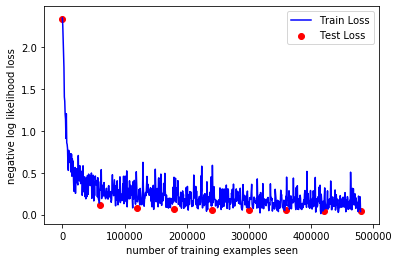

In [341]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

## Inference Example With Trained Network

In [342]:
with torch.no_grad():
  output = model(example_data.to(device))
  output = output.cpu()

/gpfs/gpfs_gl4_16mb/b9p111/fdl_sw/conda/envs/wmlce_py3_sdo/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


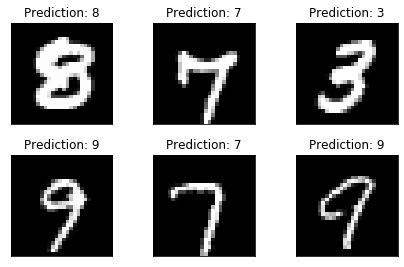

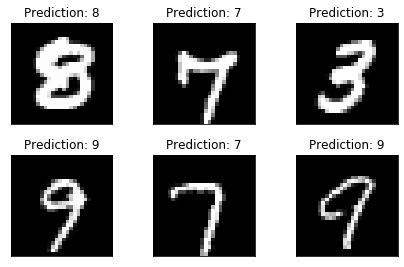

In [343]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

## Continue Training From Saved Checkpoint &amp; Final Training Results

In [338]:
# continued_network = Net()
# continued_optimizer = optim.SGD(network.parameters(), lr=learning_rate,
#                                 momentum=momentum)

# network_state_dict = torch.load(model_path)
# continued_network.load_state_dict(network_state_dict)

# optimizer_state_dict = torch.load(optimizer_path)
# continued_optimizer.load_state_dict(optimizer_state_dict)

In [339]:
# def continue_training():
#   for i in range(4, 9):
#     test_counter.append(i*len(train_loader.dataset))
#     train(i)
#     test()

# %time continue_training()

In [340]:
# fig = plt.figure()
# plt.plot(train_counter, train_losses, color='blue')
# plt.scatter(test_counter, test_losses, color='red')
# plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
# plt.xlabel('number of training examples seen')
# plt.ylabel('negative log likelihood loss')